In [1]:
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose(
    [transforms.ToTensor(), # Convert PIL image to tensor 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
    
# Load the CIFAR-10 training dataset with transformations applied
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Load the CIFAR-10 test dataset with the same transformations
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

In [3]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_sizes, dropout=None, batch_norm=None):
        super().__init__()
        self.cnn_layers = nn.Sequential()
        self.dropout = nn.Dropout(dropout) if dropout else nn.Identity()

        for idx, (input, out, kernel) in enumerate(zip(input_channels, output_channels, kernel_sizes)):
            cnn = nn.Conv2d(input, out, kernel, padding=1)
            relu = nn.ReLU()
            bn_layer = nn.BatchNorm2d(out) if batch_norm else nn.Identity()
            pooling = nn.MaxPool2d(kernel_size=2, stride=2)
            block = nn.Sequential(cnn, relu, bn_layer, pooling)
            self.cnn_layers.add_module(f'block_{idx}', block)

        self.fc = nn.Linear(128 * 4 * 4, 256)
        self.relu = nn.ReLU()
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        feature_maps = self.cnn_layers(x)
        feature_maps = feature_maps.view(feature_maps.size(0), -1)  # Flatten the tensor
        x = self.fc(feature_maps)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.out(x)
        return output


In [4]:
input_channels = [3, 32, 64]
output_channels = [32, 64, 128]
kernel_sizes = [3, 3, 3]

num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def train(batch_size, learning_rate, optim='Adam', dropout=None, batch_norm=None):
    print(f'----- batch_size: {batch_size} lr: {learning_rate} optim: {optim} ------------')
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

    criterion = nn.CrossEntropyLoss()
    model = CNN(input_channels, output_channels, kernel_sizes, dropout=dropout, batch_norm=batch_norm).to(device)
    if optim == 'RMSProp':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0


        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            total += len(targets)
            correct += predictions.eq(targets).sum().item()
        
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)


        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total += len(labels)
                correct += predictions.eq(labels).sum().item()

        test_acc = correct / total
        test_accs.append(test_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}')

    return train_losses, train_accs, test_accs


In [6]:
def plot_results(train_losses, train_accs, test_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)  # Show integer ticks on x-axis
    plt.legend()
    plt.title("Training Loss")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, test_accs, label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)  # Show integer ticks on x-axis
    plt.legend()
    plt.title("Accuracy")

    plt.tight_layout()
    plt.show()

### Hyperparams
Optimizer: Adam <br>
batch_size: 64 <br>
learning rate: 0.001

----- batch_size: 64 lr: 0.001 optim: Adam ------------
Epoch 1/20, loss: 1.3282, train_acc: 0.5193, test_acc: 0.6445
Epoch 2/20, loss: 0.8919, train_acc: 0.6845, test_acc: 0.7015
Epoch 3/20, loss: 0.7071, train_acc: 0.7538, test_acc: 0.7290
Epoch 4/20, loss: 0.5835, train_acc: 0.7960, test_acc: 0.7511
Epoch 5/20, loss: 0.4783, train_acc: 0.8330, test_acc: 0.7510
Epoch 6/20, loss: 0.3834, train_acc: 0.8642, test_acc: 0.7647
Epoch 7/20, loss: 0.3041, train_acc: 0.8918, test_acc: 0.7531
Epoch 8/20, loss: 0.2312, train_acc: 0.9173, test_acc: 0.7598
Epoch 9/20, loss: 0.1857, train_acc: 0.9324, test_acc: 0.7579
Epoch 10/20, loss: 0.1455, train_acc: 0.9481, test_acc: 0.7615
Epoch 11/20, loss: 0.1240, train_acc: 0.9547, test_acc: 0.7525
Epoch 12/20, loss: 0.1033, train_acc: 0.9645, test_acc: 0.7492
Epoch 13/20, loss: 0.1042, train_acc: 0.9623, test_acc: 0.7602
Epoch 14/20, loss: 0.0969, train_acc: 0.9669, test_acc: 0.7440
Epoch 15/20, loss: 0.0840, train_acc: 0.9712, test_acc: 0.7537
Epoch 16

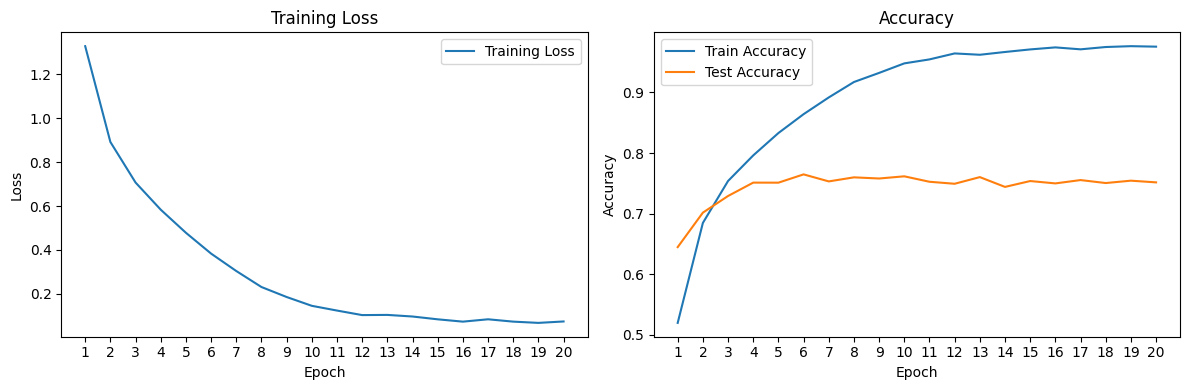

In [60]:
batch_size = 64
learning_rate = 0.001

train_losses, train_accs, test_accs = train(batch_size, learning_rate)
plot_results(train_losses, train_accs, test_accs)

batch_size: 64 <br>
learning_rate:  [0.01, 0.001, 0.0001]

----- batch_size: 64 lr: 0.01 optim: Adam ------------
Epoch 1/20, loss: 1.7688, train_acc: 0.3626, test_acc: 0.4183
Epoch 2/20, loss: 1.5702, train_acc: 0.4325, test_acc: 0.4441
Epoch 3/20, loss: 1.5105, train_acc: 0.4584, test_acc: 0.4421
Epoch 4/20, loss: 1.4865, train_acc: 0.4668, test_acc: 0.4750
Epoch 5/20, loss: 1.4596, train_acc: 0.4779, test_acc: 0.4610
Epoch 6/20, loss: 1.4408, train_acc: 0.4838, test_acc: 0.4873
Epoch 7/20, loss: 1.4207, train_acc: 0.4921, test_acc: 0.4843
Epoch 8/20, loss: 1.4209, train_acc: 0.4916, test_acc: 0.4814
Epoch 9/20, loss: 1.4048, train_acc: 0.4984, test_acc: 0.4777
Epoch 10/20, loss: 1.3976, train_acc: 0.4988, test_acc: 0.4884
Epoch 11/20, loss: 1.3971, train_acc: 0.4998, test_acc: 0.4963
Epoch 12/20, loss: 1.3893, train_acc: 0.5063, test_acc: 0.5098
Epoch 13/20, loss: 1.3781, train_acc: 0.5066, test_acc: 0.4940
Epoch 14/20, loss: 1.3707, train_acc: 0.5107, test_acc: 0.4627
Epoch 15/20, loss: 1.3803, train_acc: 0.5090, test_acc: 0.4880
Epoch 16/

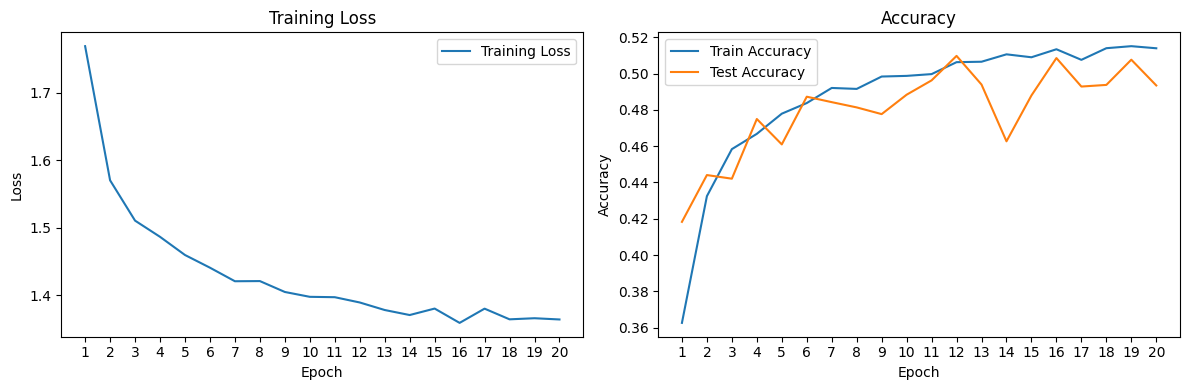

----- batch_size: 64 lr: 0.001 optim: Adam ------------
Epoch 1/20, loss: 1.3507, train_acc: 0.5107, test_acc: 0.6280
Epoch 2/20, loss: 0.9109, train_acc: 0.6788, test_acc: 0.7005
Epoch 3/20, loss: 0.7364, train_acc: 0.7412, test_acc: 0.7317
Epoch 4/20, loss: 0.6206, train_acc: 0.7830, test_acc: 0.7112
Epoch 5/20, loss: 0.5259, train_acc: 0.8134, test_acc: 0.7332
Epoch 6/20, loss: 0.4422, train_acc: 0.8448, test_acc: 0.7534
Epoch 7/20, loss: 0.3639, train_acc: 0.8717, test_acc: 0.7407
Epoch 8/20, loss: 0.2984, train_acc: 0.8933, test_acc: 0.7571
Epoch 9/20, loss: 0.2375, train_acc: 0.9148, test_acc: 0.7521
Epoch 10/20, loss: 0.1980, train_acc: 0.9285, test_acc: 0.7537
Epoch 11/20, loss: 0.1565, train_acc: 0.9442, test_acc: 0.7476
Epoch 12/20, loss: 0.1366, train_acc: 0.9510, test_acc: 0.7438
Epoch 13/20, loss: 0.1136, train_acc: 0.9593, test_acc: 0.7398
Epoch 14/20, loss: 0.1183, train_acc: 0.9579, test_acc: 0.7446
Epoch 15/20, loss: 0.1004, train_acc: 0.9641, test_acc: 0.7430
Epoch 16

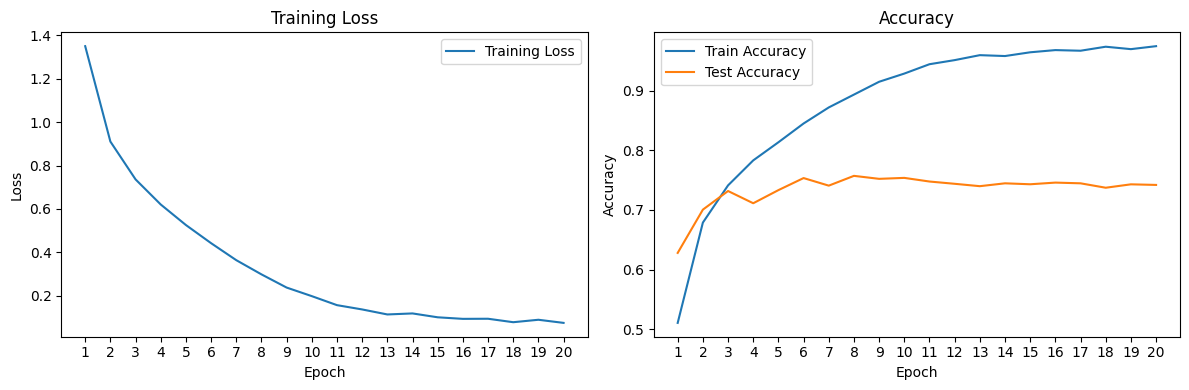

----- batch_size: 64 lr: 0.0001 optim: Adam ------------
Epoch 1/20, loss: 1.6721, train_acc: 0.3961, test_acc: 0.4927
Epoch 2/20, loss: 1.3490, train_acc: 0.5170, test_acc: 0.5449
Epoch 3/20, loss: 1.2331, train_acc: 0.5620, test_acc: 0.5815
Epoch 4/20, loss: 1.1384, train_acc: 0.6004, test_acc: 0.6093
Epoch 5/20, loss: 1.0714, train_acc: 0.6256, test_acc: 0.6196
Epoch 6/20, loss: 1.0073, train_acc: 0.6484, test_acc: 0.6457
Epoch 7/20, loss: 0.9543, train_acc: 0.6666, test_acc: 0.6702
Epoch 8/20, loss: 0.9078, train_acc: 0.6861, test_acc: 0.6761
Epoch 9/20, loss: 0.8637, train_acc: 0.7015, test_acc: 0.6840
Epoch 10/20, loss: 0.8338, train_acc: 0.7109, test_acc: 0.6916
Epoch 11/20, loss: 0.7964, train_acc: 0.7249, test_acc: 0.7035
Epoch 12/20, loss: 0.7610, train_acc: 0.7359, test_acc: 0.7045
Epoch 13/20, loss: 0.7352, train_acc: 0.7460, test_acc: 0.7116
Epoch 14/20, loss: 0.7063, train_acc: 0.7574, test_acc: 0.7139
Epoch 15/20, loss: 0.6797, train_acc: 0.7683, test_acc: 0.7236
Epoch 1

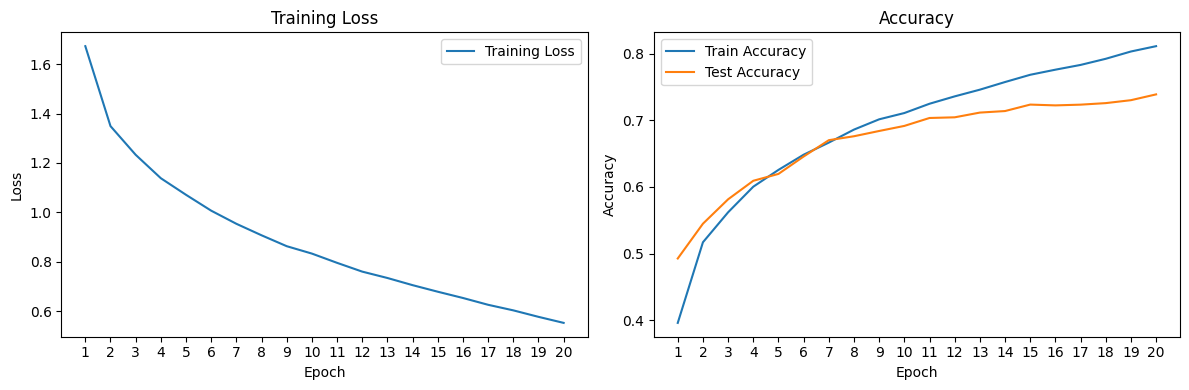

In [61]:
batch_size = 64
learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:
    train_losses, train_accs, test_accs = train(batch_size, lr)
    plot_results(train_losses, train_accs, test_accs)

learning_rate: 0.001 <br>
batch_size: [32, 64, 128]

----- batch_size: 32 lr: 0.001 optim: Adam ------------
Epoch 1/20, loss: 1.2896, train_acc: 0.5359, test_acc: 0.6495
Epoch 2/20, loss: 0.8556, train_acc: 0.6987, test_acc: 0.7227
Epoch 3/20, loss: 0.6842, train_acc: 0.7583, test_acc: 0.7436
Epoch 4/20, loss: 0.5702, train_acc: 0.8009, test_acc: 0.7511
Epoch 5/20, loss: 0.4709, train_acc: 0.8348, test_acc: 0.7593
Epoch 6/20, loss: 0.3833, train_acc: 0.8640, test_acc: 0.7487
Epoch 7/20, loss: 0.3087, train_acc: 0.8904, test_acc: 0.7422
Epoch 8/20, loss: 0.2478, train_acc: 0.9109, test_acc: 0.7550
Epoch 9/20, loss: 0.2081, train_acc: 0.9253, test_acc: 0.7548
Epoch 10/20, loss: 0.1693, train_acc: 0.9402, test_acc: 0.7495
Epoch 11/20, loss: 0.1542, train_acc: 0.9450, test_acc: 0.7461
Epoch 12/20, loss: 0.1488, train_acc: 0.9495, test_acc: 0.7436
Epoch 13/20, loss: 0.1272, train_acc: 0.9560, test_acc: 0.7451
Epoch 14/20, loss: 0.1192, train_acc: 0.9591, test_acc: 0.7446
Epoch 15/20, loss: 0.1123, train_acc: 0.9613, test_acc: 0.7509
Epoch 16

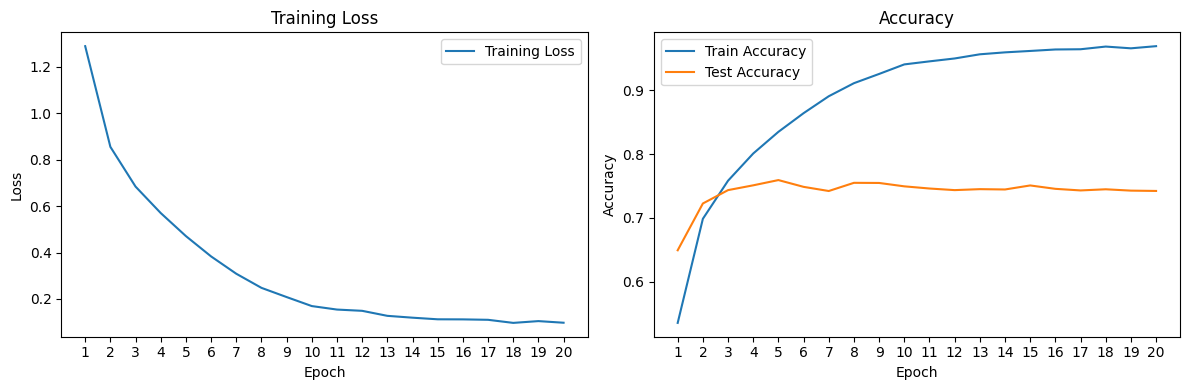

----- batch_size: 64 lr: 0.001 optim: Adam ------------
Epoch 1/20, loss: 1.3296, train_acc: 0.5217, test_acc: 0.6313
Epoch 2/20, loss: 0.8911, train_acc: 0.6829, test_acc: 0.7070
Epoch 3/20, loss: 0.7088, train_acc: 0.7516, test_acc: 0.7227
Epoch 4/20, loss: 0.5754, train_acc: 0.7974, test_acc: 0.7365
Epoch 5/20, loss: 0.4661, train_acc: 0.8365, test_acc: 0.7457
Epoch 6/20, loss: 0.3651, train_acc: 0.8718, test_acc: 0.7431
Epoch 7/20, loss: 0.2838, train_acc: 0.8995, test_acc: 0.7573
Epoch 8/20, loss: 0.2120, train_acc: 0.9247, test_acc: 0.7514
Epoch 9/20, loss: 0.1670, train_acc: 0.9401, test_acc: 0.7592
Epoch 10/20, loss: 0.1375, train_acc: 0.9515, test_acc: 0.7554
Epoch 11/20, loss: 0.1153, train_acc: 0.9602, test_acc: 0.7513
Epoch 12/20, loss: 0.1025, train_acc: 0.9636, test_acc: 0.7475
Epoch 13/20, loss: 0.0953, train_acc: 0.9672, test_acc: 0.7511
Epoch 14/20, loss: 0.0895, train_acc: 0.9691, test_acc: 0.7499
Epoch 15/20, loss: 0.0824, train_acc: 0.9717, test_acc: 0.7419
Epoch 16

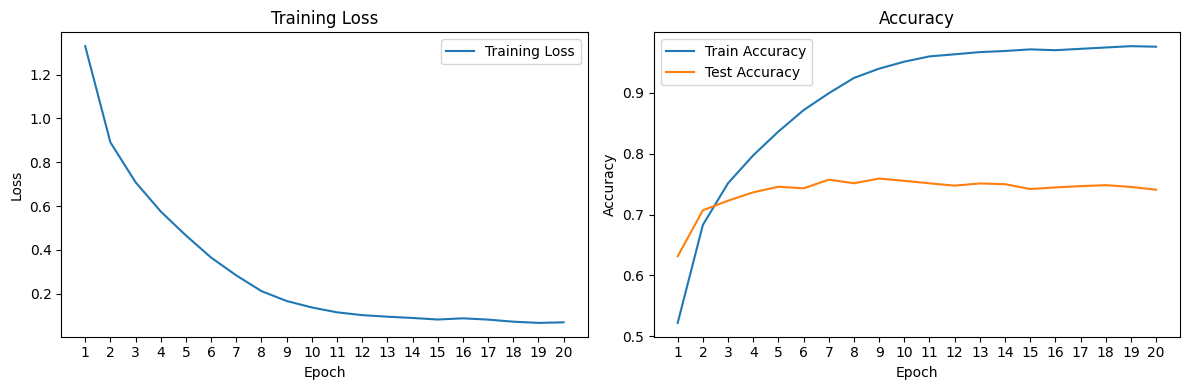

----- batch_size: 128 lr: 0.001 optim: Adam ------------
Epoch 1/20, loss: 1.3933, train_acc: 0.4944, test_acc: 0.6131
Epoch 2/20, loss: 0.9704, train_acc: 0.6602, test_acc: 0.6808
Epoch 3/20, loss: 0.7853, train_acc: 0.7256, test_acc: 0.7059
Epoch 4/20, loss: 0.6642, train_acc: 0.7668, test_acc: 0.7369
Epoch 5/20, loss: 0.5597, train_acc: 0.8054, test_acc: 0.7450
Epoch 6/20, loss: 0.4763, train_acc: 0.8322, test_acc: 0.7500
Epoch 7/20, loss: 0.3869, train_acc: 0.8657, test_acc: 0.7436
Epoch 8/20, loss: 0.3067, train_acc: 0.8934, test_acc: 0.7587
Epoch 9/20, loss: 0.2432, train_acc: 0.9150, test_acc: 0.7671
Epoch 10/20, loss: 0.1838, train_acc: 0.9366, test_acc: 0.7526
Epoch 11/20, loss: 0.1423, train_acc: 0.9504, test_acc: 0.7619
Epoch 12/20, loss: 0.1170, train_acc: 0.9593, test_acc: 0.7588
Epoch 13/20, loss: 0.0973, train_acc: 0.9664, test_acc: 0.7544
Epoch 14/20, loss: 0.0886, train_acc: 0.9690, test_acc: 0.7483
Epoch 15/20, loss: 0.0790, train_acc: 0.9725, test_acc: 0.7516
Epoch 1

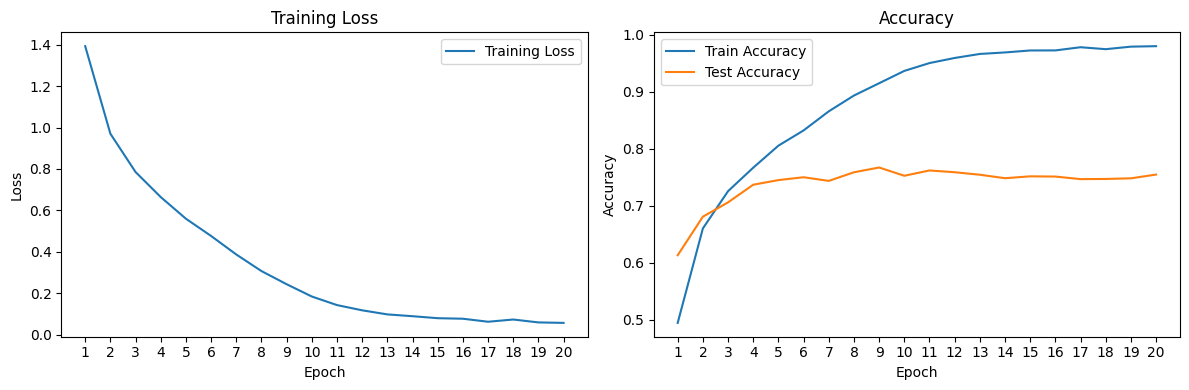

In [62]:
batch_sizes = [32, 64, 128]
learning_rate = 0.001

for batch_size in batch_sizes:
    train_losses, train_accs, test_accs = train(batch_size, learning_rate)
    plot_results(train_losses, train_accs, test_accs)

batch_size: 64 <br>
learning_rate = 0.001 <br>
Optimizer: RMSProp

----- batch_size: 64 lr: 0.001 optim: RMSProp ------------
Epoch 1/20, loss: 1.4325, train_acc: 0.4903, test_acc: 0.5117
Epoch 2/20, loss: 0.9623, train_acc: 0.6612, test_acc: 0.6070
Epoch 3/20, loss: 0.7632, train_acc: 0.7341, test_acc: 0.6786
Epoch 4/20, loss: 0.6263, train_acc: 0.7798, test_acc: 0.6956
Epoch 5/20, loss: 0.5150, train_acc: 0.8181, test_acc: 0.7123
Epoch 6/20, loss: 0.4172, train_acc: 0.8534, test_acc: 0.7214
Epoch 7/20, loss: 0.3323, train_acc: 0.8850, test_acc: 0.7572
Epoch 8/20, loss: 0.2588, train_acc: 0.9092, test_acc: 0.7201
Epoch 9/20, loss: 0.2034, train_acc: 0.9280, test_acc: 0.7510
Epoch 10/20, loss: 0.1594, train_acc: 0.9437, test_acc: 0.7586
Epoch 11/20, loss: 0.1316, train_acc: 0.9530, test_acc: 0.7577
Epoch 12/20, loss: 0.1110, train_acc: 0.9600, test_acc: 0.7303
Epoch 13/20, loss: 0.1014, train_acc: 0.9650, test_acc: 0.7263
Epoch 14/20, loss: 0.0950, train_acc: 0.9680, test_acc: 0.7068
Epoch 15/20, loss: 0.0866, train_acc: 0.9708, test_acc: 0.7465
Epoch

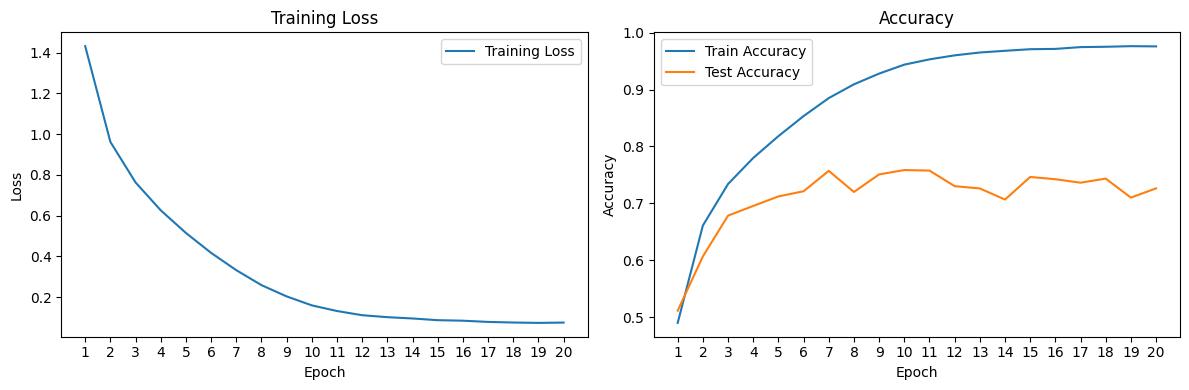

In [7]:
batch_size = 64
learning_rate = 0.001
optim = 'RMSProp'

train_losses, train_accs, test_accs = train(batch_size, learning_rate, optim)
plot_results(train_losses, train_accs, test_accs)

batch_size = 64 <br>
lr = 0.001 <br>
dropout = 0.5

----- batch_size: 64 lr: 0.001 optim: Adam ------------
Epoch 1/20, loss: 1.4628, train_acc: 0.4663, test_acc: 0.6001
Epoch 2/20, loss: 1.0592, train_acc: 0.6268, test_acc: 0.6873
Epoch 3/20, loss: 0.8787, train_acc: 0.6925, test_acc: 0.7177
Epoch 4/20, loss: 0.7744, train_acc: 0.7309, test_acc: 0.7323
Epoch 5/20, loss: 0.6921, train_acc: 0.7567, test_acc: 0.7463
Epoch 6/20, loss: 0.6304, train_acc: 0.7787, test_acc: 0.7503
Epoch 7/20, loss: 0.5672, train_acc: 0.8019, test_acc: 0.7569
Epoch 8/20, loss: 0.5217, train_acc: 0.8152, test_acc: 0.7544
Epoch 9/20, loss: 0.4776, train_acc: 0.8304, test_acc: 0.7630
Epoch 10/20, loss: 0.4343, train_acc: 0.8454, test_acc: 0.7592
Epoch 11/20, loss: 0.3996, train_acc: 0.8558, test_acc: 0.7695
Epoch 12/20, loss: 0.3739, train_acc: 0.8665, test_acc: 0.7617
Epoch 13/20, loss: 0.3498, train_acc: 0.8750, test_acc: 0.7651
Epoch 14/20, loss: 0.3261, train_acc: 0.8823, test_acc: 0.7669
Epoch 15/20, loss: 0.3069, train_acc: 0.8896, test_acc: 0.7681
Epoch 16

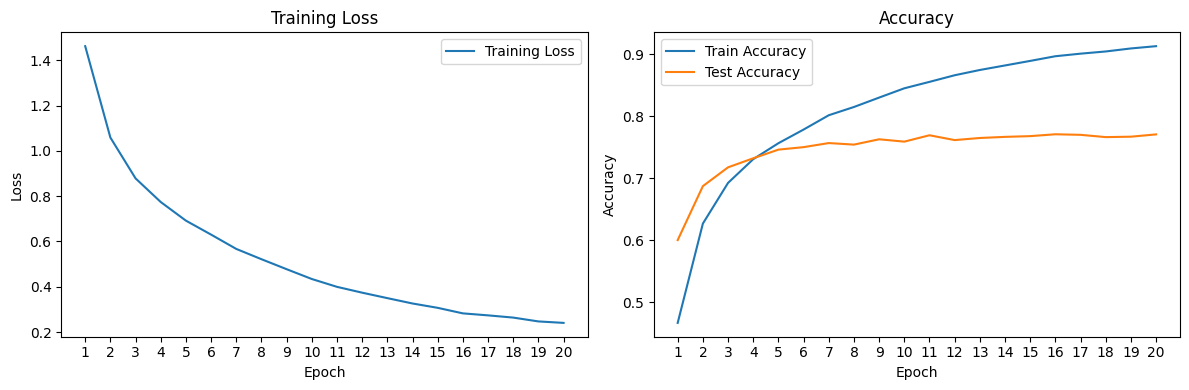

In [11]:
batch_size = 64
learning_rate = 0.001

train_losses, train_accs, test_accs = train(batch_size, learning_rate, dropout=0.5)
plot_results(train_losses, train_accs, test_accs)

----- batch_size: 64 lr: 0.001 optim: Adam ------------
Epoch 1/20, loss: 1.2498, train_acc: 0.5579, test_acc: 0.6826
Epoch 2/20, loss: 0.8975, train_acc: 0.6891, test_acc: 0.7281
Epoch 3/20, loss: 0.7586, train_acc: 0.7364, test_acc: 0.7516
Epoch 4/20, loss: 0.6483, train_acc: 0.7749, test_acc: 0.7671
Epoch 5/20, loss: 0.5756, train_acc: 0.7998, test_acc: 0.7768
Epoch 6/20, loss: 0.5059, train_acc: 0.8227, test_acc: 0.7726
Epoch 7/20, loss: 0.4527, train_acc: 0.8418, test_acc: 0.7870
Epoch 8/20, loss: 0.3995, train_acc: 0.8596, test_acc: 0.7893
Epoch 9/20, loss: 0.3608, train_acc: 0.8726, test_acc: 0.7885
Epoch 10/20, loss: 0.3295, train_acc: 0.8841, test_acc: 0.7912
Epoch 11/20, loss: 0.2967, train_acc: 0.8936, test_acc: 0.7932
Epoch 12/20, loss: 0.2782, train_acc: 0.9032, test_acc: 0.7936
Epoch 13/20, loss: 0.2560, train_acc: 0.9089, test_acc: 0.7956
Epoch 14/20, loss: 0.2384, train_acc: 0.9173, test_acc: 0.7912
Epoch 15/20, loss: 0.2220, train_acc: 0.9221, test_acc: 0.7967
Epoch 16

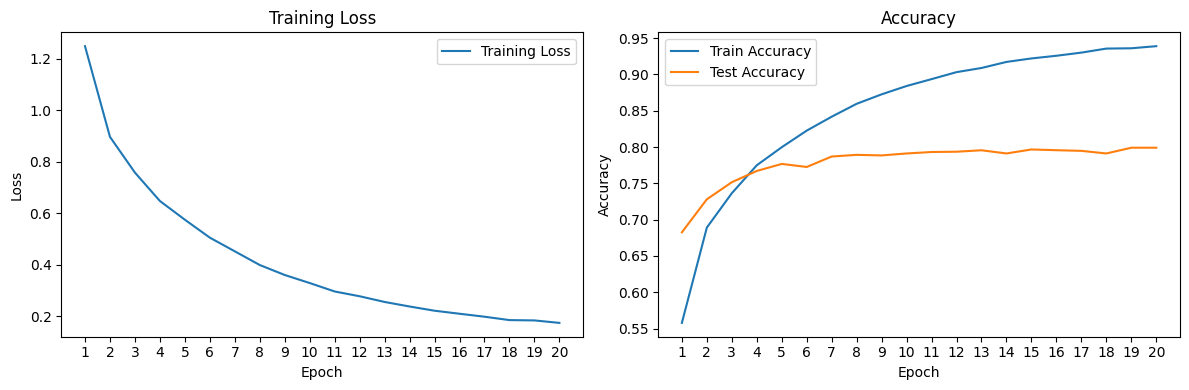

In [12]:
batch_size = 64
learning_rate = 0.001

train_losses, train_accs, test_accs = train(batch_size, learning_rate, dropout=0.5, batch_norm=True)
plot_results(train_losses, train_accs, test_accs)